In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import os

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline


np.random.seed(42)

dataDir = "./data/CUB_200_2011/"

In [9]:
# 设置数据转换
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


class CUB200(Dataset):
    def __init__(self, root_dir, subset="train", transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            subset (string): 'train', 'test', or 'val' to specify which subset of the data to load.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = pd.read_csv(
            os.path.join(root_dir, "images.txt"), sep=" ", names=["img_id", "filename"]
        )
        self.labels = pd.read_csv(
            os.path.join(root_dir, "image_class_labels.txt"),
            sep=" ",
            names=["img_id", "label"],
        )
        self.split = pd.read_csv(
            os.path.join(root_dir, "train_test_split.txt"),
            sep=" ",
            names=["img_id", "is_train"],
        )

        # Merge all information into a single DataFrame
        self.data = pd.merge(self.images, self.labels, on="img_id")
        self.data = pd.merge(self.data, self.split, on="img_id")

        # Filter data for training, testing or validation
        if subset == "train":
            self.data = self.data[self.data["is_train"] == 1]
        else:
            test_val_data = self.data[self.data["is_train"] == 0]
            indices = np.arange(test_val_data.shape[0])
            np.random.shuffle(indices)  # Shuffle indices to randomize test/val split
            split_point = int(len(indices) / 2)
            if subset == "test":
                test_indices = indices[:split_point]
                self.data = test_val_data.iloc[test_indices]
            elif subset == "val":
                val_indices = indices[split_point:]
                self.data = test_val_data.iloc[val_indices]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, "images", self.data.iloc[idx, 1])
        image = Image.open(img_name).convert("RGB")
        label = self.data.iloc[idx, 2] - 1  # Adjust label to be zero-indexed

        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = CUB200(root_dir=dataDir, subset="train", transform=transform)
test_dataset = CUB200(root_dir=dataDir, subset="test", transform=transform)
val_dataset = CUB200(root_dir=dataDir, subset="val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [56]:
# 设置数据转换
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

cub200_train = CUB200(root_dir=dataDir, subset="train", transform=transform)

# 加载数据集，这里不用批量加载，因为需要逐个分析图像
train_loader = DataLoader(cub200_train, batch_size=1, shuffle=False)

# 分析图像尺寸和计算均值与标准差
image_sizes = []
pixel_sum = torch.tensor([0.0, 0.0, 0.0])
pixel_sum_squared = torch.tensor([0.0, 0.0, 0.0])
n_pixels = 0

for i, (image, label) in enumerate(train_loader):
    # 记录尺寸
    image_sizes.append(image.size())
    # pixel_sum += image.sum(dim=[1, 2])
    # pixel_sum_squared += (image**2).sum(dim=[1, 2])
    # n_pixels += image.numel() / 3  # 总像素数（每个通道）

# 计算均值和标准差
mean = pixel_sum / n_pixels
std = (pixel_sum_squared / n_pixels - mean**2) ** 0.5

/tmp/ipykernel_1354830/93272680.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_sizes = torch.tensor(image_sizes)


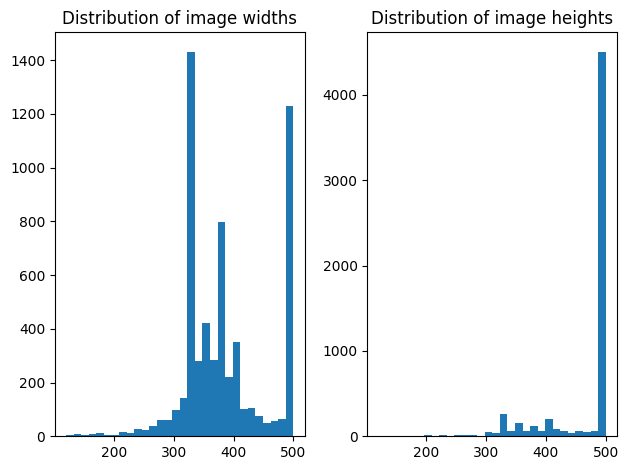

In [65]:
# plot the distribution of image heights and widths
image_sizes = torch.tensor(image_sizes)
plt.subplot(1, 2, 1)
plt.hist(image_sizes[:, 2], bins=30)
plt.title("Distribution of image widths")
plt.subplot(1, 2, 2)
plt.hist(image_sizes[:, 3], bins=30)
plt.title("Distribution of image heights")
plt.tight_layout()
plt.show()

In [20]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape, labels.shape)
    if i == 0:
        break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [10]:
len(train_dataset), len(test_dataset), len(val_dataset)

(5994, 2897, 2897)

In [38]:
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.tensorboard import SummaryWriter
import pickle


class BirdClassificationCNN(nn.Module):
    def __init__(self, num_classes=200, epochs=20):
        super(BirdClassificationCNN, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(512, num_classes)
        # self.conv1 = nn.Conv2d(1, 3, kernel_size=1)
        self.loss_record = {
            "train": [],
            "val": [],
        }
        self.accuracy_record = {
            "train": [],
            "val": [],
        }
        self.epochs = epochs
        self.load_data()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.writer = SummaryWriter()

    def forward(self, x):
        return self.resnet(x)

    # 初始化权重
    def init_weights(self):
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight)
        #     if isinstance(m, nn.Linear):
        #         nn.init.kaiming_normal_(m.weight)
        pass

    def load_data(self):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.val_loader = val_loader

    def train(self):
        # self.init_weights()

        train_loader = self.train_loader

        device = self.device
        self.to(device)
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay=0.0001)
        epochs = self.epochs
        for epoch in range(epochs):
            # running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.long().to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                # running_loss += loss.item()

            torch.save(self.state_dict(), "model.pt")

            # self.loss_record.append(running_loss / len(train_loader))
            eval_res = self.evaluate_on_train_and_val()
            eval_train, eval_val = eval_res["train"], eval_res["val"]
            print("Epoch: %d | Loss: %.4f" % (epoch, eval_train["loss"]))
            # running_loss = 0.0

            self.writer.add_scalar("Loss/train", eval_train["loss"], epoch)
            self.writer.add_scalar("Loss/test", eval_val["loss"], epoch)
            self.writer.add_scalar("Accuracy/train", eval_train["accuracy"], epoch)
            self.writer.add_scalar("Accuracy/test", eval_val["accuracy"], epoch)

            self.loss_record["train"].append(eval_train["loss"])
            self.loss_record["val"].append(eval_val["loss"])
            self.accuracy_record["train"].append(eval_train["accuracy"])
            self.accuracy_record["val"].append(eval_val["accuracy"])

        print("Finished Training")
        # save the loss record and accuracy record
        pickle.dump(self.loss_record, open("loss_record.pkl", "wb"))
        pickle.dump(self.accuracy_record, open("accuracy_record.pkl", "wb"))

    # 读取模型参数
    def read_model(self):
        self.load_state_dict(torch.load("model.pt"))

    # 在数据集上评估模型，返回总样本数和正确分类的样本数
    def evaluate(self, loader):
        device = self.device
        self.to(device)
        loss_function = nn.CrossEntropyLoss()

        correct = 0
        total = 0
        total_loss = 0.0
        with torch.no_grad():
            for data in loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.long().to(device)
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        avg_loss = total_loss / len(loader)
        accuracy = correct / total
        return accuracy, avg_loss

    # 在训练集和验证集上评估模型，并打印准确率
    def evaluate_on_train_and_val(self):
        train_accuracy, train_loss = self.evaluate(self.train_loader)
        val_accuracy, val_loss = self.evaluate(self.val_loader)
        print(
            "Accuracy of the network on the %d train data: %.2f %%"
            % (len(self.train_loader.dataset), 100 * train_accuracy)
        )
        print(
            "Accuracy of the network on the %d val data: %.2f %%"
            % (len(self.val_loader.dataset), 100 * val_accuracy)
        )
        return {
            "train": {"accuracy": train_accuracy, "loss": train_loss},
            "val": {"accuracy": val_accuracy, "loss": val_loss},
        }

    def predict_on_test(self):
        # device = self.device
        # self.to(device)
        # result = []
        # with torch.no_grad():
        #     for data in self.test_loader:
        #         inputs, _ = data
        #         inputs = inputs.to(device)
        #         outputs = self(inputs)
        #         _, predicted = torch.max(outputs.data, 1)
        #         result.extend(predicted.tolist())
        # # wirte the result to csv file
        # df = pd.DataFrame({"file": self.test_file_names, "label": result})
        # with open("../result/23210980074.csv", "w") as f:
        #     f.write(
        #         df.to_csv(index=False, lineterminator=None)
        #         .rstrip("\n")
        #         .replace("\r", "")
        #     )

        return

In [ ]:
model = BirdClassificationCNN()